# Generalised inverse Laplacian

This demonstrates a manual method to compute the inverse Laplacian of a scalar field using bits and pieces we can find lying around in windspharm. This is obviously a massive hack but it demonstrates that it is possible!
You can do all this just using `pyspharm`, which may be a better choice, but here we'll let windspharm do the work of setting up the required pyspharm objects.

## Data loading and reference results to show correctness

I'm going to use u and v wind as one normally would with windspharm, but these fields can be anything you like (omega even); in general you just need some fields with the right shape to initialise everything. I will use Iris to load, you can use any interface you like.

In [1]:
import iris

u = iris.load_cube("uwnd_mean.nc")
v = iris.load_cube("vwnd_mean.nc")

Create a VectorWind instance from the u and v wind components, then compute the vorticity and streamfunction.
I'm going to demonstrate that the manual method of computing the inverse Laplacian gives the same result as
the built-in version, which can be verified if I use vorticity as the scalar field.

In [2]:
from windspharm.iris import VectorWind

vw = VectorWind(u, v)
vrt = vw.vorticity()
psi = vw.streamfunction()

## Compute and force result back into a cube

We're going to need two things to compute the inverse Laplacian, a `Spharmt` instance for spectral transforms and the (private) `invlap` function from pyspharm.
A `windspharm.standard.VectorWind` instance has an attribute `s` that holds the `Spharmt` object we need.
The metadata interfaces are privately holding on to a windspharm.standard.VectorWind instance.

In [3]:
# Get the Spharmt instance
S = vw._api.s  # (just vw.s if you used windspharm.standard.VectorWind)

# Transform your scalar field to spectral domain, you can't use metadata here
from windspharm.tools import prep_data, recover_data
scalar_field, shape_info = prep_data(vrt.data, "tyx")
scalar_field_spec = S.grdtospec(scalar_field)

# Compute the inverse Laplacian
import spharm.spharm
ilap_spec = spharm.spharm._spherepack.invlap(scalar_field_spec, S.rsphere)
ilap = recover_data(S.spectogrd(ilap_spec), shape_info)


In [4]:
ilap_cube = u.copy()
ilap_cube.data = ilap
ilap_cube.rename("inverse_laplacian")
print(ilap_cube)

inverse_laplacian / (m/s)           (time: 12; latitude: 73; longitude: 144)
     Dimension coordinates:
          time                           x             -              -
          latitude                       -             x              -
          longitude                      -             -              x
     Scalar coordinates:
          air_pressure: 200.0 hPa
     Attributes:
          Conventions: CF-1.5
          history: Wed May  9 11:39:18 2018: ncatted -a actual_range,time,d,, uwnd_mean.nc
Wed...
          parent_stat: Mean
          statistic: Long Term Mean


## Check the results are OK

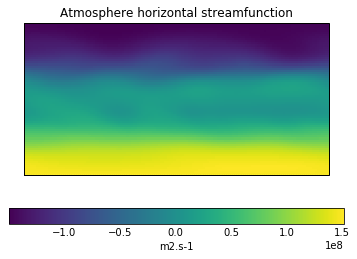

In [5]:
%matplotlib inline
import iris.quickplot

iris.quickplot.pcolormesh(psi[2])

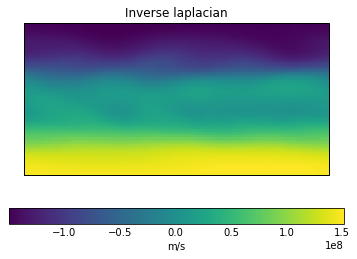

In [6]:
iris.quickplot.pcolormesh(ilap_cube[2])

In [7]:
import numpy as np

diff = psi.data - ilap_cube.data
print("Maximum absolute difference:", np.max(np.abs(diff)))
print("Mean values:", np.mean(psi.data), np.mean(ilap_cube.data))
print("Standard deviations:", np.std(psi.data), np.std(ilap_cube.data))

Maximum absolute difference: 96.0
Mean values: 3684024.8 3684025.0
Standard deviations: 92327940.0 92327944.0
